In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../data/data_processed_plant_item_10_03_22.csv')
print(data.shape)

(365785, 11)


In [3]:
print(data.head())

   Unnamed: 0       ParentItemID PlantID  Volume        Date  time_idx  month  \
0        6636  AI19565015TWICA22    5M01       4  2019-02-01         0      2   
1        6637  AI19565015TWICA22    5M01       0  2019-03-01         1      3   
2        6638  AI19565015TWICA22    5M01       0  2019-04-01         2      4   
3        6639  AI19565015TWICA22    5M01       0  2019-05-01         3      5   
4        6640  AI19565015TWICA22    5M01      52  2019-06-01         4      6   

   log_volume  avg_volume_by_material  avg_volume_by_plant  timeseries  
0    1.386294                2.222222           165.928938          80  
1  -18.420681                0.000000           248.715325          80  
2  -18.420681                0.000000           146.664384          80  
3  -18.420681                0.444444           151.811216          80  
4    3.951244               15.555556           193.533818          80  


[1.0]
[1.0, 0.3254465915490182]
[1.0, 0.3254465915490182, 0.2165141937724159]
[1.0, 0.3254465915490182, 0.2165141937724159, 0.1317525486444198]
[1.0, 0.3254465915490182, 0.2165141937724159, 0.1317525486444198, 0.06896607636585583]


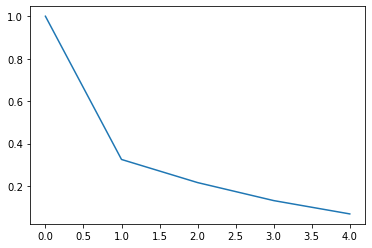

In [4]:
def autocorrelation(data):
    mean_autocorrelations = []
    timeseries_list = list(data['timeseries'].unique())
    for lag in range(0, 5):
        autocorrelations = []
        for series in timeseries_list:
            timeseries = data[data['timeseries'] == series]['Volume']
            autocorrelations.append(timeseries.autocorr(lag=lag))
        autocorrelations_array = np.array(autocorrelations)
        autocorrelations_array = autocorrelations_array[~np.isnan(autocorrelations_array)]
        mean_autocorrelations.append(np.mean(autocorrelations_array))
        print(mean_autocorrelations)
    plt.plot(range(len(mean_autocorrelations)), mean_autocorrelations)
    plt.show()


autocorrelation(data)

In [5]:
#pd.DataFrame.to_csv(filtered_data, '../data/filtered_data.csv')

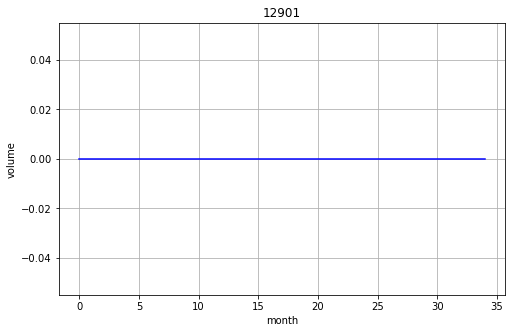

In [6]:
def select_timeseries(filtered_data):
    random_timeseries_index = np.random.randint(0, filtered_data.shape[0] / len(filtered_data['time_idx'].unique()))
    timeseries_choice = list(filtered_data['timeseries'].unique())[random_timeseries_index]
    selected_timeseries = filtered_data[filtered_data['timeseries'] == timeseries_choice]
    plt.figure(figsize=(8, 5))
    plt.grid()
    plt.title(timeseries_choice)
    plt.plot(selected_timeseries['time_idx'], selected_timeseries['Volume'], c='b')
    #plt.plot(selected_timeseries['time_idx'], selected_timeseries['log_volume'], c='r')
    plt.xlabel('month')
    plt.ylabel('volume')
    plt.show()
    return selected_timeseries


single_timeseries = select_timeseries(data)

In [80]:
def select_cols(timeseries, selected_cols):
    timeseries = timeseries[selected_cols]
    return timeseries


def train_test_split(timeseries, max_train_month):
    train = timeseries.iloc[0:max_train_month + 1]
    test = timeseries.iloc[max_train_month + 1::]
    return train, test


COL = ['Volume']
MAX_TRAIN_MONTH = 28
timeseries = select_cols(single_timeseries, COL)
train, test = train_test_split(timeseries, MAX_TRAIN_MONTH)


        Volume
215524      44
215525       6
215526       4
215527      54
215528      42
215529       8


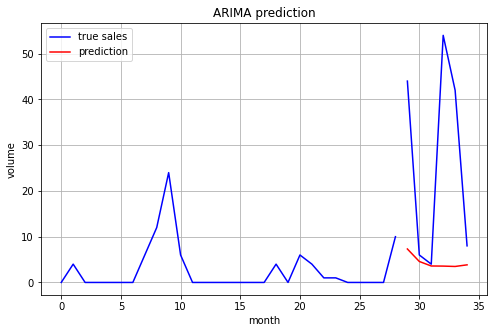

In [81]:
def model_predict(test, train):
    train = train.to_numpy()
    test = test.to_numpy()
    predictions = []
    for t in range(len(test)):
        model = ARIMA(train, order=(1, 1, 2))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = max([0, output[0]])
        #print(yhat)
        predictions.append(yhat)
        train = np.append(train, np.array(predictions))[t + 1::]
    return predictions


def plotter(predictions, test, train, max_train_month):
    print(test)
    plt.figure(figsize=(8, 5))
    plt.grid()
    plt.title('ARIMA prediction')
    plt.plot(range(len(train)), train, c='b')
    plt.plot(range(max_train_month + 1, max_train_month + 1 + len(test)), test, c='b', label='true sales')
    plt.plot(range(max_train_month + 1, max_train_month + 1 + len(test)), predictions, c='r', label='prediction')
    plt.xlabel('month')
    plt.ylabel('volume')
    plt.legend()
    plt.show()


predictions_array = model_predict(test, train)
plotter(predictions_array, test, train, MAX_TRAIN_MONTH)

**Get predictions for whole dataset using ARIMA**

In [82]:
def get_predictions(data, max_train_month, selected_col):
    print('Num of timeseries:', int(data.shape[0] / len(data['time_idx'].unique())))
    pred_array = np.zeros((int(data.shape[0] / len(data['time_idx'].unique())), len(data['time_idx'].unique()) - (1 + max_train_month)))
    test_array = np.zeros((int(data.shape[0] / len(data['time_idx'].unique())), len(data['time_idx'].unique()) - (1 + max_train_month)))
    index = 0
    for timeseries in list(data['timeseries'].unique()):
        single_timeseries = data[data['timeseries'] == timeseries]
        single_timeseries = select_cols(single_timeseries, selected_col)
        train, test = train_test_split(single_timeseries, max_train_month)
        predictions = model_predict(test, train)
        test_array[index, :] = np.squeeze(np.array(test))
        pred_array[index, :] = np.squeeze(np.array(predictions))
        index += 1
        if index % 50 == 0:
            print('Number of timeseries complete:', index, end='\r')
    return pred_array, test_array


pred_array, test_array = get_predictions(data, MAX_TRAIN_MONTH, COL)

Num of timeseries: 10451
Number of timeseries complete: 50
Number of timeseries complete: 100
Number of timeseries complete: 150
Number of timeseries complete: 200
Number of timeseries complete: 250
Number of timeseries complete: 300
Number of timeseries complete: 350
Number of timeseries complete: 400
Number of timeseries complete: 450
Number of timeseries complete: 500
Number of timeseries complete: 550
Number of timeseries complete: 600
Number of timeseries complete: 650
Number of timeseries complete: 700
Number of timeseries complete: 750
Number of timeseries complete: 800
Number of timeseries complete: 850
Number of timeseries complete: 900
Number of timeseries complete: 950
Number of timeseries complete: 1000
Number of timeseries complete: 1050
Number of timeseries complete: 1100
Number of timeseries complete: 1150
Number of timeseries complete: 1200
Number of timeseries complete: 1250
Number of timeseries complete: 1300
Number of timeseries complete: 1350
Number of timeseries co

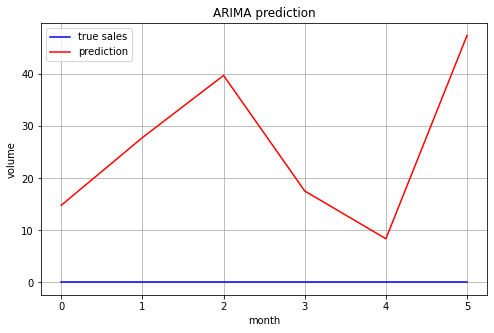

In [84]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.title('ARIMA prediction')
plt.plot(range(len(test)), test, c='b', label='true sales')
plt.plot(range(len(pred)), pred, c='r', label='prediction')
plt.xlabel('month')
plt.ylabel('volume')
plt.legend()
plt.show()

In [90]:
print(test_array[0:4])

[[203.   0.   0.   0.   0.   0.]
 [  0.   0.  10.   3.   0.   0.]
 [  0.   0.   8.   8.   4.   1.]
 [  0.  40.  38.   0.  78.  42.]]


In [87]:
np.save('../data/model_preds/ARIMA_predictions', pred_array)
np.save('../data/model_preds/actual_sales', test_array)